In [1]:
# pca stuff, yeah
# dduncan 2/1/18
# starting with dardar data which is monthly already and 36+ months,
#  break up into seasons since monthly is too noisy
# updated 22/1/18 to divide by std to standardize the PCs output, making 
#  them directly comparable across datasets :)
import glob
import scipy.ndimage as ndimage
from scipy import linalg as LA
dir = '/home/dudavid/projects/iwp/grids/' 
nx, ny = 144, 72

number dardar monthly files used:  68
1.0 593.910432206 1


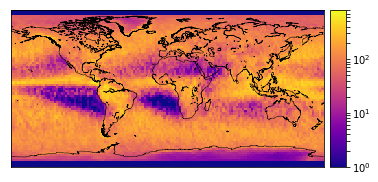

[0.0, 0.62269367390660624, 0.098378733761219694, 0.078939489009193703]
after rem 0s [0.001, 0.62269367390660624, 0.098462698854429084, 0.078835267461023248]


In [2]:
# ALL daytime DARDAR data on dendrite
dcts = sorted(glob.glob(dir+'dardar.day.144x.72y.iwptot.cts.hist.v1.0*.cts.npy'))+sorted(glob.glob(dir+'dardar.144x.72y.iwptot.cts.hist.v1.*.cts.npy'))
dtot = sorted(glob.glob(dir+'dardar.day.144x.72y.iwptot.cts.hist.v1.0*.tot.npy'))+sorted(glob.glob(dir+'dardar.144x.72y.iwptot.cts.hist.v1.*.tot.npy'))
#dtot = sorted(glob.glob(dir+'dardar.144x.72y.iwptot.cts.hist.v1.*.tot.npy'))
#print(dtot[0][70:72])
#print(dtot[0][len(dtot[0])-15:len(dtot[0])-11])
darcounts = np.zeros([4,ny,nx])
dartotss  = np.zeros([4,ny,nx])
nyrs = 5
darcountm = np.zeros([4*nyrs,ny,nx])
dartotsm  = np.zeros([4*nyrs,ny,nx])
darcount = np.zeros([ny,nx])
dartots  = np.zeros([ny,nx])
ndar = len(dcts)
print('number dardar monthly files used: ',ndar)
if ndar != len(dtot): print('unequal!')
    
darseas = np.zeros([4,ny,nx])
darseam = np.zeros([4*nyrs,ny,nx])
darmean = np.zeros([ny,nx])
for d in range(ndar):
    dc = np.load(dcts[d])
    dt = np.load(dtot[d])
    mo = dtot[d][len(dtot[d])-13:len(dtot[d])-11] # string month number
    #print(mo,dtot[d][len(dtot[d])-15:len(dtot[d])-11]) # string month number
    if mo=='12' or mo=='01' or mo=='02': se = 0
    if mo=='03' or mo=='04' or mo=='05': se = 1
    if mo=='06' or mo=='07' or mo=='08': se = 2
    if mo=='09' or mo=='10' or mo=='11': se = 3
    darcounts[se,:,:] += dc
    dartotss[se,:,:]  += dt
    darcount[:,:] += dc
    dartots[:,:]  += dt

for d in range(ndar): #seasonal but years separate (not avg'd together)
    dc = np.load(dcts[d])
    dt = np.load(dtot[d])
    mo,yr = dtot[d][len(dtot[d])-13:len(dtot[d])-11],dtot[d][len(dtot[d])-15:len(dtot[d])-13]
    #print(yr,mo)
    if yr != '12': #dardar data from 2012 is quite incomplete, just discard for this part
        if mo=='12' or mo=='01' or mo=='02': se = 0
        if mo=='03' or mo=='04' or mo=='05': se = 1
        if mo=='06' or mo=='07' or mo=='08': se = 2
        if mo=='09' or mo=='10' or mo=='11': se = 3
        if yr=='08': sm=0
        if yr=='09': sm=1
        if yr=='13': sm=2
        if yr=='14': sm=3
        if yr=='15': sm=4
        sub = sm*4+se
        #print('sub: ',sub)
        darcountm[sub,:,:] += dc
        dartotsm[sub,:,:]  += dt
    
for s in range(4*nyrs):
    dtemp = np.zeros([ny,nx])
    gu = [darcountm[s,:,:] > 0]
    dtempc = darcountm[s,:,:]
    dtempt = dartotsm[s,:,:]
    dtemp[gu] = dtempt[gu] / dtempc[gu]
    darseam[s,:,:] = dtemp[:,:] # seasonal mean (DJF/MMA/JJA/SON)
for s in range(4):
    dtemp = np.zeros([ny,nx])
    gu = [darcounts[s,:,:] > 0]
    dtempc = darcounts[s,:,:]
    dtempt = dartotss[s,:,:]
    dtemp[gu] = dtempt[gu] / dtempc[gu]
    darseas[s,:,:] = dtemp[:,:] # seasonal mean (DJF/MMA/JJA/SON)
    
darmean = np.zeros([ny,nx])
nonz = [darcount > 0]
darmean[nonz] = dartots[nonz]/darcount[nonz]  # mean of all data

# reshape 3D monthly grid to perform PC analysis:
sg = 0
darseas2d = np.zeros([4,ny*nx])
darseam2d = np.zeros([4*nyrs,ny*nx])
darseam2dxxx = np.zeros([4*nyrs,ny*nx])
darseas2dxxx = np.zeros([4,ny*nx])
darseas_smoo = np.zeros([4,ny,nx])
darseam_smoo = np.zeros([4*nyrs,ny,nx])
darmean_smoo = ndimage.gaussian_filter(darmean[:,:],sigma=(sg,sg))
grdmap((darmean_smoo*1000),-180,-90,1,800,1)
plt.show()
for d in range(4):
    darseas_smoo[d,:,:] = ndimage.gaussian_filter(darseas[d,:,:],sigma=(sg,sg))
    darseas2d[d,:] = np.reshape(darseas_smoo[d,:,:],ny*nx) - np.reshape(darmean_smoo[:,:],ny*nx) # into 2d
    #darseas2d[d,:] = np.reshape(darseas[d,:,:],ny*nx) - np.reshape(darmean[:,:],ny*nx) # into 2d
    #pgrid = ndimage.gaussian_filter((darseas[d,:,:] - darmean[:,:]), sigma=(sg,sg))
    #grdmap(np.flipud(pgrid)*1000,-180,90,-200,200,2)
for d in range(4*nyrs):
    darseam_smoo[d,:,:] = ndimage.gaussian_filter(darseam[d,:,:],sigma=(sg,sg))
    darseam2d[d,:] = np.reshape((darseam_smoo[d,:,:]-darmean_smoo[:,:]),ny*nx) # into 2d
# have to calc in separate loop if using time series of smoothed data
stddar = np.std(darseam,axis=0) # standard dev of smoothed dardar grid
print(info(stddar))
stddar[stddar < 0.001] = 0.001 # something nominal to avoid /0
print('after rem 0s',info(stddar))
for d in range(4*nyrs):
    darseam2dxxx[d,:] = np.reshape((darseam_smoo[d,:,:]-darmean_smoo[:,:])/stddar,ny*nx) # standardize data
    #pgrid = ndimage.gaussian_filter((darseam[d,:,:] - darmean[:,:]), sigma=(sg,sg))
    #grdmap(np.flipud(pgrid)*1000,-180,90,-200,200,2)
for d in range(4):
    darseas2dxxx[d,:] = np.reshape((darseas_smoo[d,:,:]-darmean_smoo[:,:])/stddar,ny*nx) # standardize data
    


number gprof monthly files used:  12
1.0 443.48112267 1


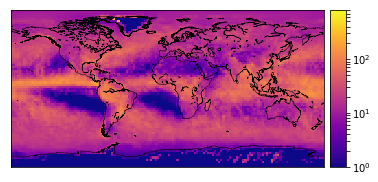

[0.0, 0.19322432826184541, 0.010886346463130258, 0.011390445743941701]
after rem 0s [1.0000000000000001e-05, 0.19322432826184541, 0.010887095218084598, 0.011389730410977043]


In [3]:
# ALL daytime GPROF data on dendrite
yr = '15' # only one year atm
gcts = sorted(glob.glob(dir+'gprofAM2.144x.72y.iwptot.cts.hist.v1.'+yr+'*.cts.npy'))
gtot = sorted(glob.glob(dir+'gprofAM2.144x.72y.iwptot.cts.hist.v1.'+yr+'*.tot.npy'))
gcounts = np.zeros([4,ny,nx])
gtotss  = np.zeros([4,ny,nx])
gyrs = 1
gcountm = np.zeros([4*gyrs,ny,nx])
gtotsm  = np.zeros([4*gyrs,ny,nx])
gcount = np.zeros([ny,nx])
gtots  = np.zeros([ny,nx])
ngpr = len(gtot)
print('number gprof monthly files used: ',ngpr)
if ngpr != len(gtot): print('unequal!')
    
#gseas = np.zeros([4,ny,nx])
gseam = np.zeros([4*gyrs,ny,nx])
gmean = np.zeros([ny,nx])
for d in range(ngpr):
    gc = np.load(gcts[d])
    gt = np.load(gtot[d])
    mo = gtot[d][len(gtot[d])-13:len(gtot[d])-11] # string month number
    #print(mo,dtot[d][len(dtot[d])-15:len(dtot[d])-11]) # string month number
    if mo=='12' or mo=='01' or mo=='02': se = 0
    if mo=='03' or mo=='04' or mo=='05': se = 1
    if mo=='06' or mo=='07' or mo=='08': se = 2
    if mo=='09' or mo=='10' or mo=='11': se = 3
    gcounts[se,:,:] += gc
    gtotss[se,:,:]  += gt
    gcount[:,:] += gc
    gtots[:,:]  += gt

for d in range(ngpr): #seasonal but years separate (not avg'd together)
    gc = np.load(gcts[d])
    gt = np.load(gtot[d])
    mo,yr = gtot[d][len(gtot[d])-13:len(gtot[d])-11],gtot[d][len(gtot[d])-15:len(gtot[d])-13]
    #print(yr,mo)
    if mo=='12' or mo=='01' or mo=='02': se = 0
    if mo=='03' or mo=='04' or mo=='05': se = 1
    if mo=='06' or mo=='07' or mo=='08': se = 2
    if mo=='09' or mo=='10' or mo=='11': se = 3
    #if yr=='08': sm=0
    #if yr=='09': sm=1
    #if yr=='13': sm=2
    #if yr=='14': sm=3
    if yr=='15': sm=0 #4  # just the one year for now
    sub = sm*4+se
    gcountm[sub,:,:] += gc
    gtotsm[sub,:,:]  += gt
    
for s in range(4*gyrs):
    gtemp = np.zeros([ny,nx])
    gu = [gcountm[s,:,:] > 0]
    gtempc = gcountm[s,:,:]
    gtempt = gtotsm[s,:,:]
    gtemp[gu] = gtempt[gu] / gtempc[gu]
    gseam[s,:,:] = gtemp[:,:] # seasonal mean (DJF/MMA/JJA/SON)
#for s in range(4):
#    dtemp = np.zeros([ny,nx])
#    gu = [darcounts[s,:,:] > 0]
#    dtempc = darcounts[s,:,:]
#    dtempt = dartotss[s,:,:]
#    dtemp[gu] = dtempt[gu] / dtempc[gu]
#    darseas[s,:,:] = dtemp[:,:] # seasonal mean (DJF/MMA/JJA/SON)
    
gmean = np.zeros([ny,nx])
gnonz = [gcount > 0]
gmean[gnonz] = gtots[gnonz]/gcount[gnonz]  # mean of all data

# reshape 3D monthly grid to perform PC analysis:
sg = 0
#gseas2d = np.zeros([4,ny*nx])
gseam2d = np.zeros([4*gyrs,ny*nx])
gseam2dxxx = np.zeros([4*gyrs,ny*nx])
#gseas_smoo = np.zeros([4,ny,nx])
gseam_smoo = np.zeros([4*gyrs,ny,nx])
gmean_smoo = ndimage.gaussian_filter(gmean[:,:],sigma=(sg,sg))
grdmap((gmean_smoo*1000),-180,-90,1,800,1)
plt.show()
#for d in range(4):
#    gseas_smoo[d,:,:] = ndimage.gaussian_filter(gseas[d,:,:],sigma=(sg,sg))
#    gseas2d[d,:] = np.reshape(gseas_smoo[d,:,:],ny*nx) - np.reshape(gmean_smoo[:,:],ny*nx) # into 2d
    #darseas2d[d,:] = np.reshape(darseas[d,:,:],ny*nx) - np.reshape(darmean[:,:],ny*nx) # into 2d
    #pgrid = ndimage.gaussian_filter((darseas[d,:,:] - darmean[:,:]), sigma=(sg,sg))
    #grdmap(np.flipud(pgrid)*1000,-180,90,-200,200,2)
for d in range(4*gyrs):
    gseam_smoo[d,:,:] = ndimage.gaussian_filter(gseam[d,:,:],sigma=(sg,sg))
    gseam2d[d,:] = np.reshape(gseam_smoo[d,:,:],ny*nx) - np.reshape(gmean_smoo[:,:],ny*nx) # into 2d
    pgrid = ndimage.gaussian_filter((gseam[d,:,:] - gmean[:,:]), sigma=(sg,sg))
    #grdmap(np.flipud(pgrid)*1000,-180,90,-200,200,2)
    
gstd = np.std(gseam_smoo,axis=0)
print(info(gstd))
gstd[gstd <= 0.00001] = 0.00001 # something nominal to avoid /0
print('after rem 0s',info(gstd))
for d in range(4*gyrs):  # standardize for PCA
    gseam2dxxx[d,:] = np.reshape((gseam_smoo[d,:,:] - gmean_smoo[:,:]) / gstd,ny*nx) 
    


In [4]:
# read in ERA5 and MERRA seasonal data
sg2 = 0
eny, enx = 361, 720
mny, mnx = 360, 720
#eyrs = ['15']#,'14','15','16'] #if wanting just annual variation (for % var explained comparable, for instance)
eyrs = ['13','14','15','16']
efis, efi = [],[]
ordr = [0,2,1,3]
for y in eyrs:
    etmps= sorted(glob.glob('grids/era5.*.'+str(enx)+'x.'+str(eny)+'y.12_6to18_3hrly.iwp.swp.v1.'+y+'*.sgrid.npy'))
    efis.extend([etmps[i] for i in ordr])
    etmp = sorted(glob.glob('grids/era5.*.'+str(enx)+'x.'+str(eny)+'y.12_6to18_3hrly.iwp.swp.v1.'+y+'*.grid.npy'))
    efi.extend([etmp[i] for i in ordr])
#print('efis',efis)
mfi = sorted(glob.glob('grids/merra.*.'+str(mnx)+'x.'+str(mny)+'y.12_6to18_1hrly.iwp.v1.15*.grid.npy'))
ecyrs = int(len(efi)/4) # should match len(eyrs) above
mryrs = int(len(mfi)/4)
print('ec/mr years: ',ecyrs,mryrs)
mfi = [mfi[k] for k in  ordr[0:4]]
#print(mfi,efis)

ec_swp = np.zeros([4*ecyrs,eny,enx])
ec_iwp = np.zeros([4*ecyrs,eny,enx])
mr_iwp = np.zeros([4*mryrs,mny,mnx])
for s in range(4*mryrs):
    mr_iwp[s,:,:] = np.load(mfi[s])
for s in range(4*ecyrs):
    ec_iwp[s,:,:] = np.load(efi[s])
    ec_swp[s,:,:] = np.load(efis[s])
    
ec_mean = np.mean(ec_iwp+ec_swp, axis=0)
mr_mean = np.mean(mr_iwp, axis=0)
ec_mean_smoo = ndimage.gaussian_filter(ec_mean,sigma=(sg2,sg2))
mr_mean_smoo = ndimage.gaussian_filter(mr_mean,sigma=(sg2,sg2))
#f27 = plt.figure(figsize=[9,15])
#grdmap(ec_mean_smoo,-180,90,.001,.8,1)
#f28 = plt.figure(figsize=[9,15])
#grdmap(mr_mean_smoo,-180,90,.001,.8,1)

ec2d, mr2d = np.zeros([4*ecyrs,enx*eny]), np.zeros([4*mryrs,mnx*mny])
ec2dxxx, mr2dxxx = np.zeros([4*ecyrs,enx*eny]), np.zeros([4*mryrs,mnx*mny])
ec3d, mr3d = np.zeros([4*ecyrs,eny,enx]), np.zeros([4*mryrs,mny,mnx]) # smoothed!!
for s in range(4*ecyrs):
    ec3d[s,:,:] = ndimage.gaussian_filter(ec_iwp[s,:,:]+ec_swp[s,:,:],sigma=(sg2,sg2))
    ec2d[s,:] = np.reshape(ec3d[s,:,:],eny*enx) - np.reshape(ec_mean_smoo[:,:],eny*enx)
for s in range(4*mryrs):
    mr3d[s,:,:] = ndimage.gaussian_filter(mr_iwp[s,:,:],sigma=(sg2,sg2))
    mr2d[s,:] = np.reshape(mr3d[s,:,:],mny*mnx) - np.reshape(mr_mean_smoo[:,:],mny*mnx)
ecstd = np.std(ec3d,axis=0)
mrstd = np.std(mr3d,axis=0)
print(info(ecstd),info(mrstd))
ecstd[ecstd <= 0.0001] = 0.0001
mrstd[mrstd <= 0.0001] = 0.0001
for s in range(4*ecyrs):
    ec2dxxx[s,:] = np.reshape((ec3d[s,:,:]-ec_mean_smoo[:,:])/ecstd,eny*enx)
for s in range(4*mryrs):
    mr2dxxx[s,:] = np.reshape((mr3d[s,:,:]-mr_mean_smoo[:,:])/mrstd,mny*mnx)

ec/mr years:  4 1
[8.3748909226630751e-05, 0.39177763542188782, 0.028355716700098708, 0.023439037390062097] [1.9224952850875097e-05, 0.048654141097449415, 0.0055226767279239483, 0.0046808588981890609]


In [5]:
# PC analysis
npc = 3  # how many PCs to save
#m, n = darseas2d.shape
#R = np.cov(darseas2d, rowvar=False)
#evals, evecs = LA.eig(R)
#idx = np.argsort(evals)[::-1] #sort eigenvalues
#evecs = evecs[:,idx] #reorder
## sort eigenvectors according to same index
#evals = evals[idx]
# select the first n eigenvectors (n is desired dimension
# of rescaled data array, or dims_rescaled_data)
#evecs = evecs[:, :npc]
from sklearn.decomposition import PCA
def pca2(data, pc_count = None):
    pca = PCA(n_components = 4) # can choose solver too, etc.
    return pca.fit_transform(data), pca.explained_variance_ratio_

#PCs, varex = pca2(np.transpose(darseas2d),npc)
#mPCs, mvarex = pca2(np.transpose(darseas2dxxx),npc) # for 1yr only (avg'd together)
mPCs, mvarex = pca2(np.transpose(darseam2dxxx),npc)
mrPCs, mrvarex = pca2(np.transpose(mr2dxxx),npc)
ecPCs, ecvarex = pca2(np.transpose(ec2dxxx),npc)
gPCs, gvarex = pca2(np.transpose(gseam2dxxx),npc)
#PCs = pca2(np.transpose(darseas2d),npc)
#print('100*varex[0:npc])
print('Variance explained by first '+str(npc)+' PCs')
print('DAR ',100*mvarex[0:npc])
print('MERRA ',100*mrvarex[0:npc])
print('ERA5 ',100*ecvarex[0:npc])
print('GPROF ',100*gvarex[0:npc])

Variance explained by first 3 PCs
DAR  [ 14.0465407    6.91310953   6.69912537]
MERRA  [ 53.27718021  27.19763202  19.52518777]
ERA5  [ 28.21905971  13.48058542   7.35924047]
GPROF  [ 48.4159197   23.33286973  20.08430534]


[-3.6228500735521556, 4.2151784746560521, 0.17872543917568587, 1.6281693338005785]


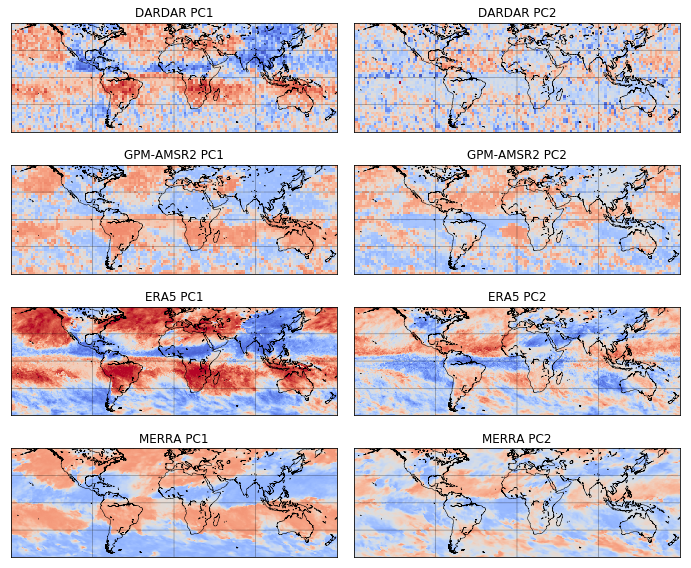

In [6]:
#print(info(bill),bill.shape)
dmpc,mrpc,ecpc = np.zeros([npc,ny,nx]),np.zeros([npc,mny,mnx]),np.zeros([npc,eny,enx])
gpc = np.zeros([npc,ny,nx])
for p in range(npc):
    #dpc[p,:,:] = np.reshape(PCs[:,p],[ny,nx])
    dmpc[p,:,:]= np.reshape(mPCs[:,p],[ny,nx])
    mrpc[p,:,:]= np.reshape(mrPCs[:,p],[mny,mnx])
    ecpc[p,:,:]= np.reshape(ecPCs[:,p],[eny,enx])
    gpc[p,:,:] = np.reshape(gPCs[:,p],[ny,nx])
    
lim = 4 #.1
ns = -60
dms=[-90,0,90]
dps=[-30,0,30]
#print(ny,mny,eny) ## 72,360,361 -- so offsets are 12,60,60
#print(int((ns+90)/2.5),int((ns+90)/2.5))
dmpc = dmpc[:,int((ns+90)/2.5):ny-int((ns+90)/2.5),:]
gpc = gpc[:,int((ns+90)/2.5):ny-int((ns+90)/2.5),:]
ecpc = ecpc[:,int((ns+90)/0.5):eny-int((ns+90)/0.5),:]
mrpc = mrpc[:,int((ns+90)/0.5):mny-int((ns+90)/0.5),:]

# try using subplots: [barely got anywhere here... save for another time (may not be
#  a great/easy way to use grdmap call as it's written, so maybe multiple lines per
#  plot are necessary with basemap calls done here directly)]
from mpl_toolkits.basemap import Basemap
from matplotlib import cm

lamin,lomin = ns,-180
ys, xs = np.shape(dmpc[0,:,:]) # grid size for lat and lon
lons = np.linspace(lomin,abs(lomin),xs)
lats = np.linspace(lamin,abs(lamin),ys)
eys, exs = np.shape(ecpc[0,:,:]) # grid size for lat and lon
elons,elats = np.linspace(lomin,abs(lomin),exs),np.linspace(lamin,abs(lamin),eys)
mys, mxs = np.shape(mrpc[0,:,:]) # grid size for lat and lon
mlons,mlats = np.linspace(lomin,abs(lomin),mxs),np.linspace(lamin,abs(lamin),mys)

fig,ax = plt.subplots(nrows=4, ncols=2, figsize=[12,10]) #width,height
plt.subplots_adjust(wspace=0.05)

    
m = Basemap(projection='cyl',resolution='l',llcrnrlat=lamin,urcrnrlat=abs(lamin),llcrnrlon=lomin,urcrnrlon=lomin+360,ax=ax[0,0])
m.drawcoastlines(linewidth=0.5)
m.drawparallels(dps,linewidth=0.5),m.drawmeridians(dms,linewidth=0.5)
x, y = m(lons, lats)
m.pcolormesh(x,y, -1*(dmpc[0,:,:]), vmin=-lim,vmax=lim,cmap=cm.coolwarm,latlon=True)
ax[0,0].set_title('DARDAR PC1')
ax[0,1].set_title('DARDAR PC2')
ax[1,0].set_title('GPM-AMSR2 PC1')
ax[1,1].set_title('GPM-AMSR2 PC2')
ax[2,0].set_title('ERA5 PC1')
ax[2,1].set_title('ERA5 PC2')
ax[3,0].set_title('MERRA PC1')
ax[3,1].set_title('MERRA PC2')
print(info(ecpc))
m = Basemap(projection='cyl',resolution='l',llcrnrlat=lamin,urcrnrlat=abs(lamin),llcrnrlon=lomin,urcrnrlon=lomin+360,ax=ax[0,1])
m.drawcoastlines(linewidth=0.5)
m.drawparallels(dps,linewidth=0.5),m.drawmeridians(dms,linewidth=0.5)
m.pcolormesh(x,y, dmpc[1,:,:], vmin=-lim,vmax=lim,cmap=cm.coolwarm,latlon=True)
m = Basemap(projection='cyl',resolution='l',llcrnrlat=lamin,urcrnrlat=abs(lamin),llcrnrlon=lomin,urcrnrlon=lomin+360,ax=ax[1,0])
m.drawcoastlines(linewidth=0.5)
m.drawparallels(dps,linewidth=0.5),m.drawmeridians(dms,linewidth=0.5)
m.pcolormesh(x,y,gpc[0,:,:], vmin=-lim,vmax=lim,cmap=cm.coolwarm,latlon=True)
m = Basemap(projection='cyl',resolution='l',llcrnrlat=lamin,urcrnrlat=abs(lamin),llcrnrlon=lomin,urcrnrlon=lomin+360,ax=ax[1,1])
m.drawcoastlines(linewidth=0.5)
m.drawparallels(dps,linewidth=0.5),m.drawmeridians(dms,linewidth=0.5)
m.pcolormesh(x,y,gpc[1,:,:], vmin=-lim,vmax=lim,cmap=cm.coolwarm,latlon=True)
ex, ey = m(elons, elats)
mx, my = m(mlons, mlats)
m = Basemap(projection='cyl',resolution='l',llcrnrlat=lamin,urcrnrlat=abs(lamin),llcrnrlon=lomin,urcrnrlon=lomin+360,ax=ax[2,0])
m.drawcoastlines(linewidth=0.5)
m.drawparallels(dps,linewidth=0.5),m.drawmeridians(dms,linewidth=0.5)
m.pcolormesh(ex,ey,np.flipud(ecpc[0,:,:]), vmin=-lim,vmax=lim,cmap=cm.coolwarm,latlon=True)
m = Basemap(projection='cyl',resolution='l',llcrnrlat=lamin,urcrnrlat=abs(lamin),llcrnrlon=lomin,urcrnrlon=lomin+360,ax=ax[2,1])
m.drawcoastlines(linewidth=0.5)
m.drawparallels(dps,linewidth=0.5),m.drawmeridians(dms,linewidth=0.5)
m.pcolormesh(ex,ey,np.flipud(ecpc[1,:,:]), vmin=-lim,vmax=lim,cmap=cm.coolwarm,latlon=True)
m = Basemap(projection='cyl',resolution='l',llcrnrlat=lamin,urcrnrlat=abs(lamin),llcrnrlon=lomin,urcrnrlon=lomin+360,ax=ax[3,0])
m.drawcoastlines(linewidth=0.5)
m.drawparallels(dps,linewidth=0.5),m.drawmeridians(dms,linewidth=0.5)
m.pcolormesh(mx,my,np.flipud(mrpc[0,:,:]), vmin=-lim,vmax=lim,cmap=cm.coolwarm,latlon=True)
m = Basemap(projection='cyl',resolution='l',llcrnrlat=lamin,urcrnrlat=abs(lamin),llcrnrlon=lomin,urcrnrlon=lomin+360,ax=ax[3,1])
m.drawcoastlines(linewidth=0.5)
m.drawparallels(dps,linewidth=0.5),m.drawmeridians(dms,linewidth=0.5)
m.pcolormesh(mx,my,np.flipud(mrpc[1,:,:]), vmin=-lim,vmax=lim,cmap=cm.coolwarm,latlon=True)
plt.show()
fig.savefig('img/pcs_all_v4.png',dpi=300,bbox_inches='tight')

# go from 60N to 60S
#grdmap(-1*(dmpc[0,:,:]),-180,ns,-lim,lim,2,'DARDAR PC1')
#grdmap(np.flipud(mrpc[0,:,:]),-180,ns,-lim,lim,2,'MERRA PC1')
#grdmap(np.flipud(ecpc[0,:,:]),-180,ns,-lim,lim,2,'ERA5 PC1')
#grdmap((gpc[0,:,:]),-180,ns,-lim,lim,2,'GPM PC1')
#grdmap((dmpc[1,:,:]),-180,ns,-lim,lim,2,'DARDAR PC2')
#grdmap(np.flipud(mrpc[1,:,:]),-180,ns,-lim,lim,2,'MERRA PC2')
#grdmap(np.flipud(ecpc[1,:,:]),-180,ns,-lim,lim,2,'ERA5 PC2')
#grdmap(-1*(gpc[1,:,:]),-180,ns,-lim,lim,2,'GPM PC2')

